# Postmating response in axenic and control _D. melanogaster_ females

Load packages and functions:

In [1]:
## Packages to load
req_packages = c("Biobase", "cluster", "cowplot", "cummeRbund", 
                 "data.table", "DESeq", "edgeR", "ggplot2", "ggpubr", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", "lattice", 
                 "heatmap3", "imager", "pheatmap", "plotly", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "splitstackshape", "statmod", "stringr", "tidyverse",
                 "wesanderson", "VennDiagram", "viridis")
## load them, quietly
invisible(suppressWarnings(suppressMessages(lapply(req_packages, require, character.only = TRUE))))

## Load custom functions from file:
source("Functions.R")

## The Cowplot package changes the default themes of ggplot2. Set the bw theme with larger font sizes like so:
# theme_set(theme_bw(base_size = 16))
## ... or set the default theme
theme_set(theme_gray())

## suppress excessive VennDiagram log files
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

NULL

Some raw files need to be processed to produce auxiliary files needed below. Running a script in the "Misc" folder should do it:

In [2]:
# system('./Misc/initial_file_modifications.sh')

Load read count data:

In [3]:
counts_bt2 = read.table("eXpress/express.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)
# counts_hs2 = read.table("Hisat2/gene_counts.csv", header=T, row.names=1, sep = ',')

Load the gene features data related to the Hisat2 pipeline (NEEDS FIXING):

In [4]:
# gene.features = read.csv("StringTie/features.txt", header = T, sep = "\t")

Output an ID matching object for the Hisat2 dataset:

In [5]:
# comp_IDs = unique(subset(gene.features, select = c("gene_id", "ref_gene_id", "gene_name")))

ERROR: Error in subset(gene.features, select = c("gene_id", "ref_gene_id", "gene_name")): object 'gene.features' not found


Load annotation files:

In [6]:
annotation = read.csv("Annotoations/fbgn_annotation_ID_fb_2018_04_mod.tsv", header = T, check.names = F, sep ="\t")

Load the transcript lengths for the eXpress data:

In [7]:
bt2_trans_lengths = read.csv("eXpress/transcriptome/transcript_lengths.txt", header = T, sep = "\t")

Load the gene-to-transcript mapping:

In [8]:
gene_trans_map = read.table("eXpress/transcriptome/dmel-all-transcript-r6.23.gene_trans_map", header = F, sep = "\t")
colnames(gene_trans_map) = c("gene_id", "transcript_id")

Generate a gene length object for the eXpress data:

In [9]:
# Merge transcript length file with gene-to-trans file:
tmpMrge = merge(bt2_trans_lengths, gene_trans_map)
# Select only the length and gene_id columns
tmpMrge = as.data.table(subset(tmpMrge, select = c("length", "gene_id")))
# For each gene ID entry, select the entry with largest value in the "length" column:
bt2_gene_lengths = tmpMrge[tmpMrge[, .I[which.max(length)], by=gene_id]$V1]
# remove un-needed intermediate objects
rm(tmpMrge)

.. and for the Hisat2 data, we'll use the `gene.features` object to extract gene lengths:

In [10]:
# # subset the columns with coordinates and gene IDs:
# tmpNum = subset(gene.features, select = c("gene_id", "min", "max"))
# # Add a length column, calculated as the absolute value of the difference between coordinate ends
# tmpNum$length = abs(tmpNum$max - tmpNum$min)
# # Select only the length and gene_id columns
# tmpNum = as.data.table(subset(tmpNum, select = c("length", "gene_id")))
# # For each gene ID entry, select the entry with largest value in the "length" column:
# hs2_gene_lengths = tmpNum[tmpNum[, .I[which.max(length)], by=gene_id]$V1]
# hs2_gene_lengths_complete = merge(hs2_gene_lengths, comp_IDs, by.x = "gene_id", by.y = "gene_id", all.x = T)
# # remove un-needed intermediate objects
# rm(tmpNum)

Generate sample info object:

In [11]:
sampleData = read.table("Misc/samples.txt", header = F, check.names = F, fill = T)
sampleInfo = sampleData
colnames(sampleInfo) = c("Sample", "Replicate")

sampleInfo$Female = ifelse(grepl("^A",sampleInfo$Sample), "axenic", "control")

sampleInfo$Male = ifelse(grepl("A$", sampleInfo$Sample), "axenic", ifelse(grepl("C$", sampleInfo$Sample), "control", "none"))

sampleInfo$Handler = ifelse(grepl("3|4", sampleInfo$Replicate), "Yasir", "Sofie")

sampleInfo$Status = ifelse(grepl("none", sampleInfo$Male), "virgin", "mated")

Output library size object:

In [12]:
LibSizes <- as.data.frame(colSums(counts_bt2))
libSizes <- cbind(sample = row.names(LibSizes), LibSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("replicate", "counts")
libSizes$sample = gsub("_.*", "", libSizes$replicate)

Make a barplot of library sizes:

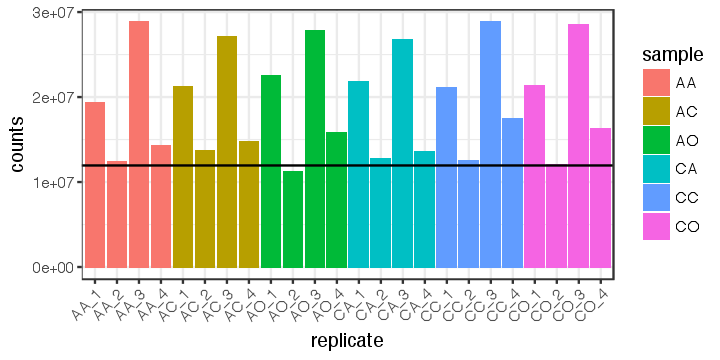

In [13]:
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("Figures/Library_sizes.pdf", width = 12, height = 4)
ggplot(libSizes, aes(replicate, counts, fill = sample)) + 
    geom_bar(stat="identity", position = "dodge") + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    geom_hline(yintercept = 12000000) 
# dev.off()

### Differential expression analysis (eXpress):

First, filter out genes with very low expression from the counts matrix. We'll use a minimum cutoff of 1 CPM in at least 4 samples:

In [31]:
counts_bt2 = subset(counts_bt2, rownames(counts_bt2) %!in% wierd_genes)
cpm_bt2 <- cpm(counts_bt2)
thresh_bt2 <- cpm_bt2 > 1
keep_bt2 <- rowSums(thresh_bt2) >= 4
countsKeep_bt2 <- counts_bt2[keep_bt2,]
# countsKeep_bt2 <- subset(countsKeep_bt2, rownames(countsKeep_bt2) %!in% wierd_genes)
dim(countsKeep_bt2)

[1] 7013   24

Now define the groupings by sample and set up the design matrix:

In [32]:
groups = factor(sampleInfo$Sample)
design = model.matrix( ~ 0 + groups)
colnames(design) <- levels(groups)
rownames(design) <- sampleInfo$Replicate

Create the DGElist object and GLM fit:

In [33]:
dgeList <- DGEList(counts = countsKeep_bt2, group = groups)
dgeList <- calcNormFactors(dgeList)
dgeList <- estimateCommonDisp(dgeList)
dgeList <- estimateTagwiseDisp(dgeList)
dgeList_fit <- glmFit(dgeList, design)
summary(dgeList$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01162 0.03652 0.04945 0.07195 0.07925 1.68700 

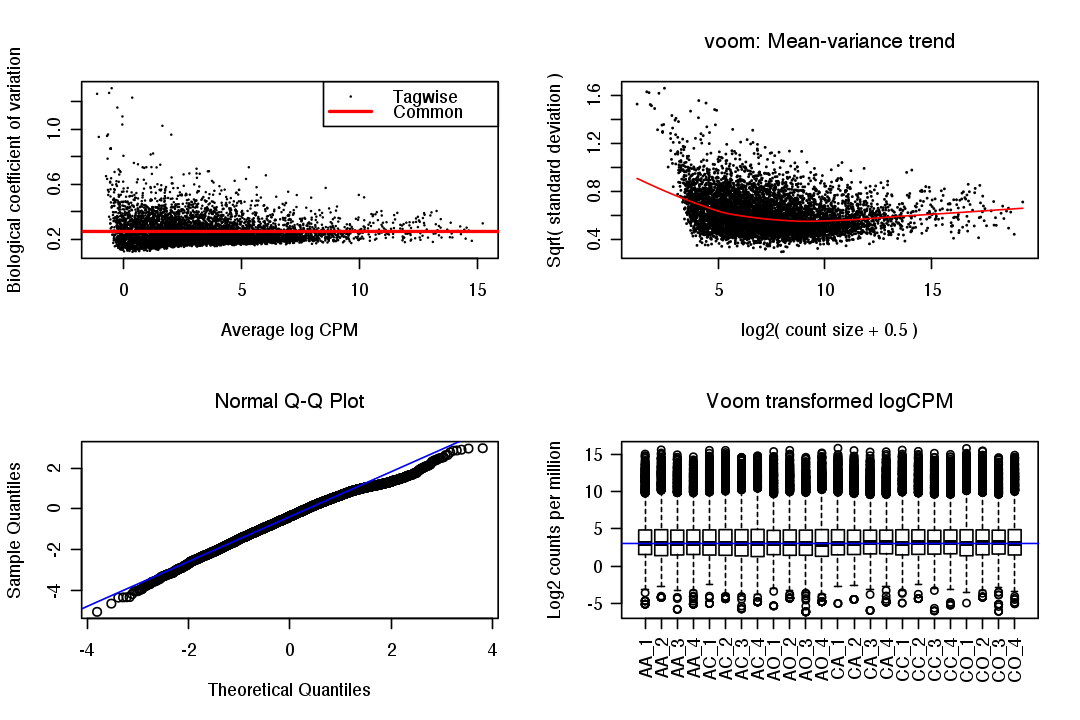

In [34]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList)
# mean-variance trend
virgin.voom = voom(dgeList, design, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(virgin.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(virgin.voom$E),col="blue")

Generate a correlation plot between replicates:

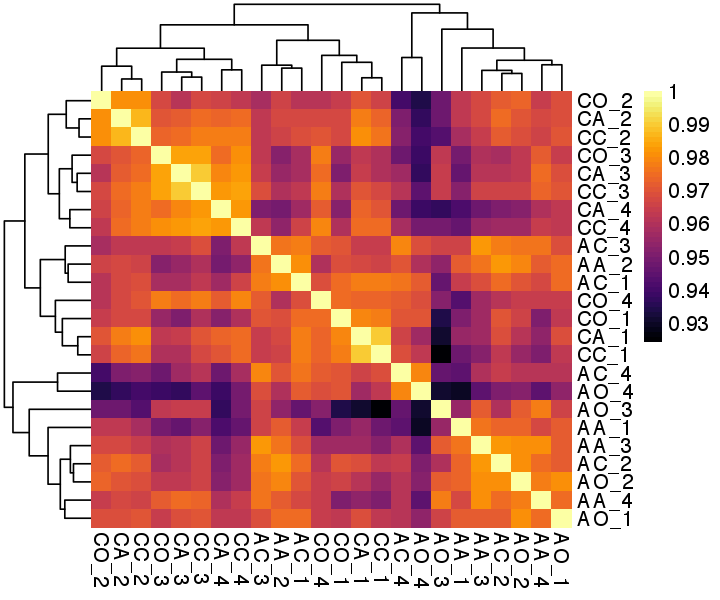

In [35]:
## Plot sample correlation
data = log2(countsKeep_bt2+1)
# colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

options(repr.plot.width = 6, repr.plot.height = 5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(50),
  border_color      = NA,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#   filename          = "Figures/repTract_sample_correlations.pdf",
#   width             = 6, 
#   height            = 5,
  fontsize          = 12    
)

Hmmmm.... wierd groupings by replicate. Look at an MDS plot:

In [36]:
mdsObj <- plotMDS(dgeList, plot = F)$cmdscale.out
mdsObj <- as.data.frame(as.matrix(mdsObj))
mdsObj$replicate <- rownames(mdsObj)
colnames(mdsObj) = c("dim1", "dim2", "replicate")
mdsObj = merge(mdsObj, sampleInfo, by.x = "replicate", by.y = "Replicate")
mdsObj$replicate_num = gsub(".*_", "", mdsObj$replicate)

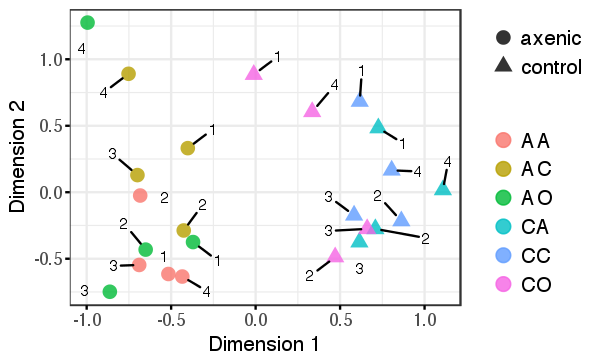

In [37]:
options(repr.plot.width = 5, repr.plot.height = 3)

# pdf("MDS.plot.pdf", width = 5, height = 3)
ggscatter(mdsObj, 
              x = "dim1", 
              y = "dim2",
              color = "Sample",
              shape = "Female",
              size = 3.5,
              alpha = 0.8, 
#               ellipse = T, 
#               mean.point = T,
#               star.plot = TRUE,
              ggtheme = theme_bw(),
              repel = "Time",) + 
#                 stat_conf_ellipse(aes(color = Time, fill = Time), alpha = 0.1, geom = "polygon") + 
                theme(axis.text = element_text(size = 10), legend.title = element_blank(), axis.title = element_text(size = 12), legend.text = element_text(size = 12)) +
                geom_text_repel(aes(label=replicate_num), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
#                 scale_colour_manual(values = c("#00c28f","#e93c00","#1c8200","#bda2ff")) +
#                 scale_fill_manual(values = c("#00c28f","#e93c00","#1c8200","#bda2ff")) +
                labs ( x = "Dimension 1", y = "Dimension 2")
# dev.off()

In [40]:
FBgn_to_symbol = subset(annotation, select = c("gene_symbol", "primary_FBgn"))

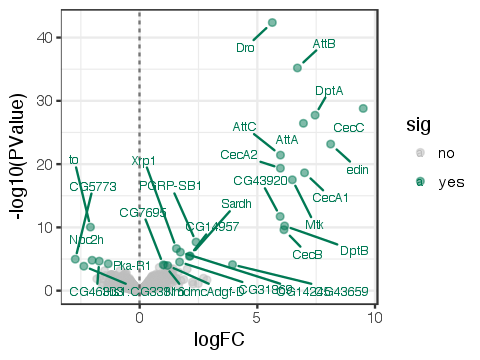

In [43]:
within_controls <- makeContrasts(CO-AO,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)


options(repr.plot.width = 4, repr.plot.height = 3)
(CA.vs.CO.gg = ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes" & ),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
#     labs(title = "control females mated to axenic\nmales vs. virgin control females", size = 2) +
    scale_colour_manual(values = c("gray","#007954")) +
    theme_bw())

In [29]:
wierd_genes = subset(lrt.control.table, sig == "yes" & logFC > 1)$gene
length(wierd_genes)

[1] 719

In [30]:
wierd_genes

[1] "FBgn0000047" "FBgn0000078" "FBgn0000079" "FBgn0000355" "FBgn0000356"
  [6] "FBgn0000357" "FBgn0000358" "FBgn0000359" "FBgn0000473" "FBgn0000477"
 [11] "FBgn0001089" "FBgn0001258" "FBgn0001263" "FBgn0001285" "FBgn0002565"
 [16] "FBgn0002569" "FBgn0002570" "FBgn0002571" "FBgn0002578" "FBgn0002579"
 [21] "FBgn0002772" "FBgn0002773" "FBgn0002789" "FBgn0002868" "FBgn0002869"
 [26] "FBgn0002938" "FBgn0003356" "FBgn0003357" "FBgn0003358" "FBgn0003863"
 [31] "FBgn0003961" "FBgn0003965" "FBgn0004045" "FBgn0004047" "FBgn0004228"
 [36] "FBgn0004425" "FBgn0004428" "FBgn0004429" "FBgn0004431" "FBgn0004512"
 [41] "FBgn0004554" "FBgn0004629" "FBgn0005670" "FBgn0010019" "FBgn0010038"
 [46] "FBgn0010041" "FBgn0010043" "FBgn0010044" "FBgn0010241" "FBgn0010357"
 [51] "FBgn0010358" "FBgn0010359" "FBgn0010387" "FBgn0010401" "FBgn0010423"
 [56] "FBgn0010425" "FBgn0011281" "FBgn0011293" "FBgn0011294" "FBgn0011554"
 [61] "FBgn0011555" "FBgn0011556" "FBgn0011576" "FBgn0011822" "FBgn0011834"
 [66] "FBgn0012037" "FBgn0013325" "FBgn0014019" "FBgn0014031" "FBgn0014380"
 [71] "FBgn0014464" "FBgn0014903" "FBgn0015001" "FBgn0015010" "FBgn0015034"
 [76] "FBgn0015037" "FBgn0015038" "FBgn0015039" "FBgn0015040" "FBgn0015316"
 [81] "FBgn0016675" "FBgn0016715" "FBgn0019643" "FBgn0019928" "FBgn0019929"
 [86] "FBgn0019940" "FBgn0020506" "FBgn0020508" "FBgn0020906" "FBgn0020907"
 [91] "FBgn0022355" "FBgn0023479" "FBgn0023495" "FBgn0024293" "FBgn0024361"
 [96] "FBgn0024980" "FBgn0024995" "FBgn0024997" "FBgn0025454" "FBgn0025583"
[101] "FBgn0025620" "FBgn0025692" "FBgn0025709" "FBgn0026314" "FBgn0026562"
[106] "FBgn0026565" "FBgn0026721" "FBgn0026878" "FBgn0027073" "FBgn0027556"
[111] "FBgn0027586" "FBgn0027611" "FBgn0027790" "FBgn0027844" "FBgn0027929"
[116] "FBgn0028381" "FBgn0028396" "FBgn0028491" "FBgn0028527" "FBgn0028532"
[121] "FBgn0028533" "FBgn0028534" "FBgn0028537" "FBgn0028562" "FBgn0028583"
[126] "FBgn0028699" "FBgn0028920" "FBgn0028945" "FBgn0028949" "FBgn0028950"
[131] "FBgn0028983" "FBgn0029172" "FBgn0029507" "FBgn0029608" "FBgn0029697"
[136] "FBgn0029766" "FBgn0029769" "FBgn0029826" "FBgn0029827" "FBgn0029932"
[141] "FBgn0029990" "FBgn0030040" "FBgn0030073" "FBgn0030148" "FBgn0030157"
[146] "FBgn0030237" "FBgn0030261" "FBgn0030272" "FBgn0030438" "FBgn0030539"
[151] "FBgn0030688" "FBgn0030774" "FBgn0030775" "FBgn0030776" "FBgn0030777"
[156] "FBgn0030837" "FBgn0030847" "FBgn0030928" "FBgn0030929" "FBgn0031002"
[161] "FBgn0031033" "FBgn0031176" "FBgn0031245" "FBgn0031248" "FBgn0031249"
[166] "FBgn0031277" "FBgn0031313" "FBgn0031373" "FBgn0031432" "FBgn0031514"
[171] "FBgn0031523" "FBgn0031533" "FBgn0031547" "FBgn0031559" "FBgn0031579"
[176] "FBgn0031580" "FBgn0031653" "FBgn0031654" "FBgn0031693" "FBgn0031701"
[181] "FBgn0031717" "FBgn0031801" "FBgn0031813" "FBgn0031857" "FBgn0031865"
[186] "FBgn0031910" "FBgn0031913" "FBgn0031914" "FBgn0031929" "FBgn0031930"
[191] "FBgn0032002" "FBgn0032049" "FBgn0032066" "FBgn0032068" "FBgn0032069"
[196] "FBgn0032074" "FBgn0032075" "FBgn0032085" "FBgn0032087" "FBgn0032088"
[201] "FBgn0032126" "FBgn0032140" "FBgn0032144" "FBgn0032167" "FBgn0032235"
[206] "FBgn0032264" "FBgn0032280" "FBgn0032281" "FBgn0032283" "FBgn0032299"
[211] "FBgn0032318" "FBgn0032322" "FBgn0032373" "FBgn0032381" "FBgn0032422"
[216] "FBgn0032505" "FBgn0032614" "FBgn0032665" "FBgn0032669" "FBgn0032726"
[221] "FBgn0032770" "FBgn0032773" "FBgn0032779" "FBgn0032788" "FBgn0032789"
[226] "FBgn0032803" "FBgn0032835" "FBgn0032836" "FBgn0032839" "FBgn0032889"
[231] "FBgn0032896" "FBgn0033027" "FBgn0033047" "FBgn0033093" "FBgn0033124"
[236] "FBgn0033138" "FBgn0033188" "FBgn0033204" "FBgn0033215" "FBgn0033216"
[241] "FBgn0033221" "FBgn0033222" "FBgn0033294" "FBgn0033296" "FBgn0033297"
[246] "FBgn0033301" "FBgn0033320" "FBgn0033327" "FBgn0033366" "FBgn0033367"
[251] "FBgn0033395" "FBgn0033397" "FBgn0033423" "FBgn0033437" "FBgn0033446"
[256] "FBgn0033502" "FBgn0033543" "FBgn0033582" "FBgn0033592" "FBgn0033710"
[261] "FBgn0033723" "FBgn0033733" "FBgn0033760" "F

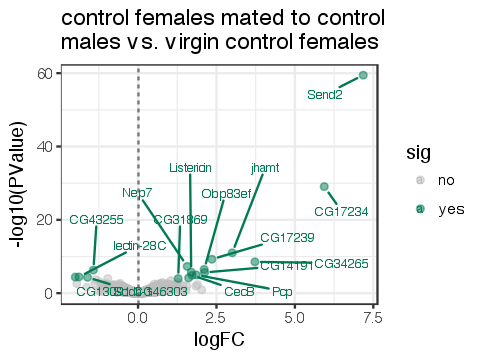

In [44]:
within_controls <- makeContrasts(CC.vs.CO=CC-CO,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
(CC.vs.CO.gg = ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "control females mated to control\nmales vs. virgin control females", size = 2) +
    scale_colour_manual(values = c("gray","#007954")) +
    theme_bw())

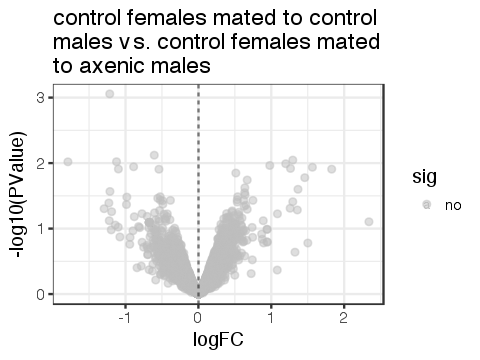

In [45]:
within_controls <- makeContrasts(CC.vs.CA=CC-CA,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
(CC.vs.CA.gg = ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "control females mated to control\nmales vs. control females mated\nto axenic males", size = 2) +
    scale_colour_manual(values = c("gray","#007954")) +
    theme_bw())

In [49]:
within_controls <- makeContrasts(AA.vs.AO=AA-AO,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
AAvAO.lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

# options(repr.plot.width = 4, repr.plot.height = 3)
# (AA.vs.AO.gg = ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
#     geom_point(alpha = 0.5) +
#     geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
#     geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
#                     force = 10, 
# #                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
#                     fontface = "bold", 
#                     size = 2.5) +
#     labs(title = "axenic females mated to axenic\nmales vs. virgin axenic females", size = 2) +
#     scale_colour_manual(values = c("gray","#ff6c5d")) +
#     theme_bw())

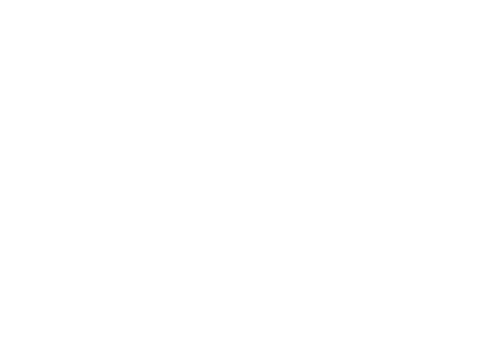

In [48]:
within_controls <- makeContrasts(AC.vs.AO=AC-AO,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
ACvAO.lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

# options(repr.plot.width = 4, repr.plot.height = 3)
# (AC.vs.AO.gg = ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
#     geom_point(alpha = 0.5) +
#     geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
#     geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
#                     force = 10, 
# #                     inherit.aes = F, 
# #                     box.padding = unit(0.35, "lines"), 
# #                     point.padding = unit(0.5, "lines"), 
#                     fontface = "bold", 
#                     size = 2.5) +
#     labs(title = "axenic females mated to control\nmales vs. virgin axenic females", size = 2) +
#     scale_colour_manual(values = c("gray","#ff6c5d")) +
#     theme_bw())

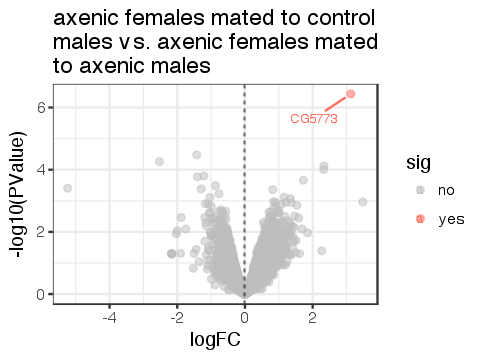

In [62]:
within_controls <- makeContrasts((AA-AO)-(AC-AO),
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
(AA.vs.AC.gg = ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "axenic females mated to control\nmales vs. axenic females mated\nto axenic males", size = 2) +
    scale_colour_manual(values = c("gray","#ff6c5d")) +
    theme_bw())

gene,logFC,logCPM,LR,PValue,FDR,sig,gene_symbol
FBgn0000008,0.007266444,0.4934029,0.0007911669,0.9775603,0.9989083,no,a
FBgn0000017,-0.165246716,0.7643945,0.3164395289,0.5737553,0.9904477,no,Abl
FBgn0000018,-0.119381289,1.9743731,0.2778293282,0.5981275,0.9924513,no,abo
FBgn0000032,0.253498989,2.5900283,1.2430809214,0.2648781,0.9519461,no,Acph-1
FBgn0000042,0.162037064,7.1957944,0.1764694722,0.6744250,0.9924513,no,Act5C
FBgn0000043,0.026721698,4.9185522,0.0148500950,0.9030091,0.9989083,no,Act42A


gene,logFC,logCPM,LR,PValue,FDR,sig,gene_symbol
FBgn0000008,-0.12983085,0.4934029,0.24595105,0.61994061,0.9787464,no,a
FBgn0000017,0.08227076,0.7643945,0.08087674,0.77611278,0.9902829,no,Abl
FBgn0000018,-0.17091784,1.9743731,0.56129585,0.45373860,0.9664622,no,abo
FBgn0000032,-0.45659064,2.5900283,3.80875584,0.05098531,0.8153620,no,Acph-1
FBgn0000042,-0.64003944,7.1957944,2.72993286,0.09848343,0.8760040,no,Act5C
FBgn0000043,-0.22267871,4.9185522,1.02451458,0.31145053,0.9529261,no,Act42A


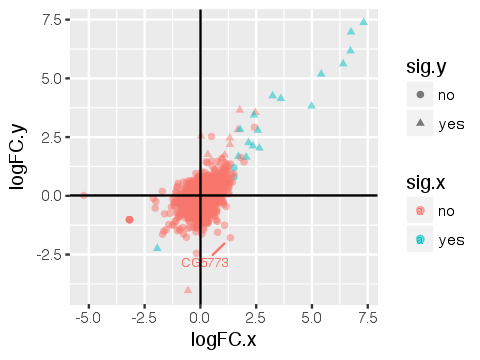

In [72]:
head(AAvAO.lrt.control.table)
head(ACvAO.lrt.control.table)
tmpDF = merge(AAvAO.lrt.control.table, ACvAO.lrt.control.table, by.x = "gene", by.y = "gene", all.x = T)
ggplot(tmpDF, aes(logFC.x, logFC.y, colour = sig.x, shape = sig.y)) + geom_point(alpha = 0.5) +
    geom_text_repel(data = filter(tmpDF, gene_symbol.x == "CG5773"),aes(label=gene_symbol.y), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) + geom_vline(xintercept = 0) + geom_hline(yintercept = 0)

In [52]:
nrow(AAvAO.lrt.control.table)
nrow(ACvAO.lrt.control.table)

[1] 7013

[1] 7013

In [58]:
options(repr.plot.width = 12, repr.plot.height = 6)
# pdf("Figures/pairwiseDE.pdf", width = 12, height = 6)
plot_grid(CC.vs.CO.gg, CA.vs.CO.gg, CC.vs.CA.gg, AC.vs.AO.gg, AA.vs.AO.gg, AA.vs.AC.gg, ncol = 3)
# dev.off()

ERROR: Error in eval(expr, envir, enclos): object 'gene_symbol' not found


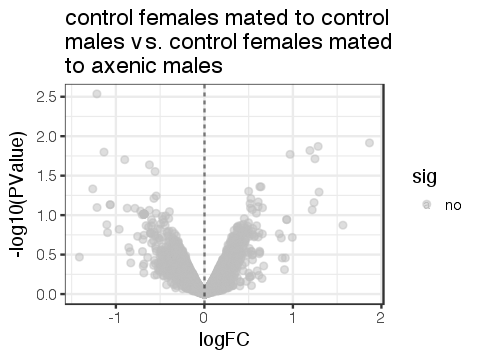

In [41]:
within_controls <- makeContrasts(CC.vs.CA=CC-CA,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "control females mated to control\nmales vs. control females mated\nto axenic males", size = 2) +
    scale_colour_manual(values = c("gray","#e93c00")) +
    theme_bw()

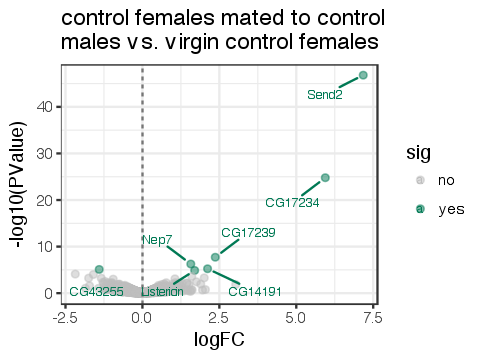

In [43]:
within_controls <- makeContrasts(CC.vs.CO=CC-CO,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "control females mated to control\nmales vs. virgin control females", size = 2) +
    scale_colour_manual(values = c("gray","#007954")) +
    theme_bw()

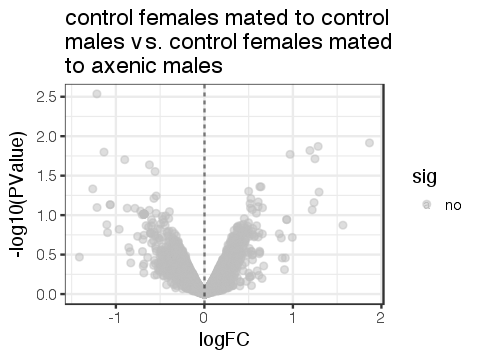

In [44]:
within_controls <- makeContrasts(CC.vs.CA=CC-CA,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "control females mated to control\nmales vs. control females mated\nto axenic males", size = 2) +
    scale_colour_manual(values = c("gray","#007954")) +
    theme_bw()

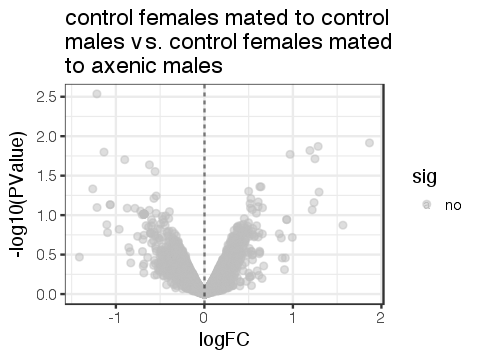

In [41]:
within_controls <- makeContrasts(CC.vs.CA=CC-CA,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "control females mated to control\nmales vs. control females mated\nto axenic males", size = 2) +
    scale_colour_manual(values = c("gray","#e93c00")) +
    theme_bw()

In [226]:
mel_modENCODE = read.csv("~/Dropbox/Aedes-aegypti_files/Ethan/Analyses/proteomics/Other_species_proteomes/gene_rpkm_report_fb_2018_02_subset.tsv", header = T, sep = "\t")
mel_modENCODE_subset = subset(mel_modENCODE, select = c("FBgn_ID", "RNASource_name", "RPKM_value"))
mel_modENCODE_matrix = cast(mel_modENCODE_subset, FBgn_ID~RNASource_name, value = "RPKM_value")
mel_modENCODE_matrix2 <- mel_modENCODE_matrix[,-1]
rownames(mel_modENCODE_matrix2) <- mel_modENCODE_matrix[,1]

In [227]:
wierdMatrix = subset(mel_modENCODE_matrix2, rownames(mel_modENCODE_matrix2) %in% wierd_genes)

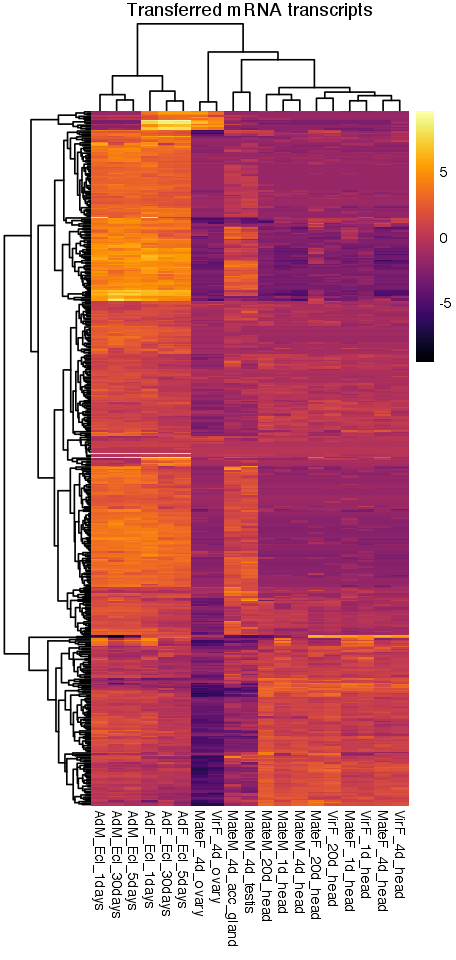

In [229]:
data = log2(wierdMatrix+1)
data = t(scale(t(data), scale=F))
# data[data < -3] = -3
# data[data > 3] = 3

options(repr.plot.width = 3.8, repr.plot.height = 8)
pheatmap(
  mat               = data,
  color             = inferno(100),
#   breaks            = mat_breaks,
  border_color      = NA,
#   labels_col        = c("carcass", "head", "ovaries", "rep. tract"),
  show_colnames     = TRUE,
  show_rownames     = FALSE,
#   annotation_row    = annotationType,
#   annotation_colors = mat_colors,
  drop_levels       = TRUE,
#   cluster_col    = FALSE,
  annotation_names_row = F,
  main              = "Transferred mRNA transcripts",
#   filename          = "Figures/transferred_mRNAs_heatmap.pdf",
#   width             = 3.8, 
#   height            = 5,
  fontsize          = 8    
)